# Import basic library

In [98]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from glob import glob

In [99]:
class_dict = {0 : 'Fake',
              1 : 'Real'}

In [100]:
import cv2
import matplotlib.pyplot as plt
def show_image_from_path(image_path):
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is None:
            raise FileNotFoundError("Image file not found.")
        plt.imshow(img, cmap = 'gray')
        plt.title(class_dict[int(image_path.split('/')[-2])])
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Error: An unexpected error occurred: {e}")


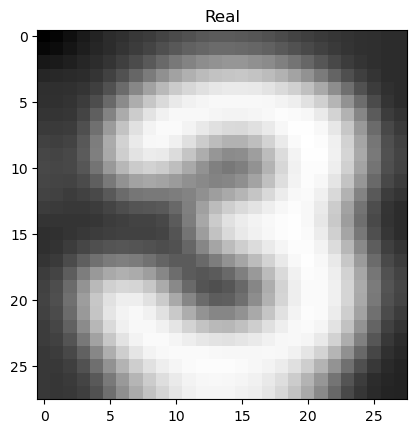

In [101]:
# Example usage:
image_path = "/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1/R_ (1).png"
show_image_from_path(image_path)

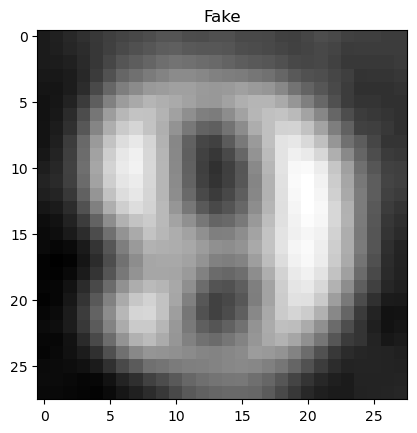

In [102]:
# Example usage:
image_path = "/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0/F_ (10).jpg"
show_image_from_path(image_path)

In [103]:
from glob import glob
def get_image_shapes_in_directory(directory_path):
    image_shapes = []
    for filename in tqdm(glob(directory_path+'/*')):
        file_path = os.path.join(directory_path, filename)
        if os.path.isfile(file_path):
            try:
                img = cv2.imread(file_path)
                if img is not None:
                    image_shapes.append(img.shape)
                else:
                    print(f"Warning: Unable to read {filename} as an image.")
            except Exception as e:
                print(f"Error: An unexpected error occurred while processing {filename}: {e}")
    return image_shapes


In [104]:
# Example usage:
directory_path = "/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/0"
image_shapes = get_image_shapes_in_directory(directory_path)
# Display the shapes
print('-------------------- Fake Image shape --------------------')
print(set(image_shapes))


100%|██████████| 487/487 [00:00<00:00, 509.11it/s]

-------------------- Fake Image shape --------------------
{(28, 28, 3)}


In [105]:
# Example usage:
directory_path = "/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป/1"
image_shapes = get_image_shapes_in_directory(directory_path)
# Display the shapes
print('-------------------- Real Image shape --------------------')
print(set(image_shapes))

100%|██████████| 514/514 [00:01<00:00, 475.11it/s]

-------------------- Real Image shape --------------------
{(28, 28, 3)}


In [106]:
# Example usage:
directory_path = "/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test"
image_shapes = get_image_shapes_in_directory(directory_path)
# Display the shapes
print('-------------------- Image test shape --------------------')
print(set(image_shapes))

100%|██████████| 1010/1010 [00:01<00:00, 638.92it/s]

-------------------- Image test shape --------------------
{(28, 28, 3)}


# Import Fast ai

In [107]:
from fastai.vision.all import *
import torch

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [109]:
class ToGrayscale(Transform):
    def encodes(self, x: PILImage):
        return x.convert('L')

In [110]:
dls = ImageDataLoaders.from_folder(path = '/kaggle/input/hackathon-online-realfakenumbers/Train_1000/Train_1000รูป',
                                   valid_pct=0.2,
                                   item_tfms=ToGrayscale(),
                                   device = device)

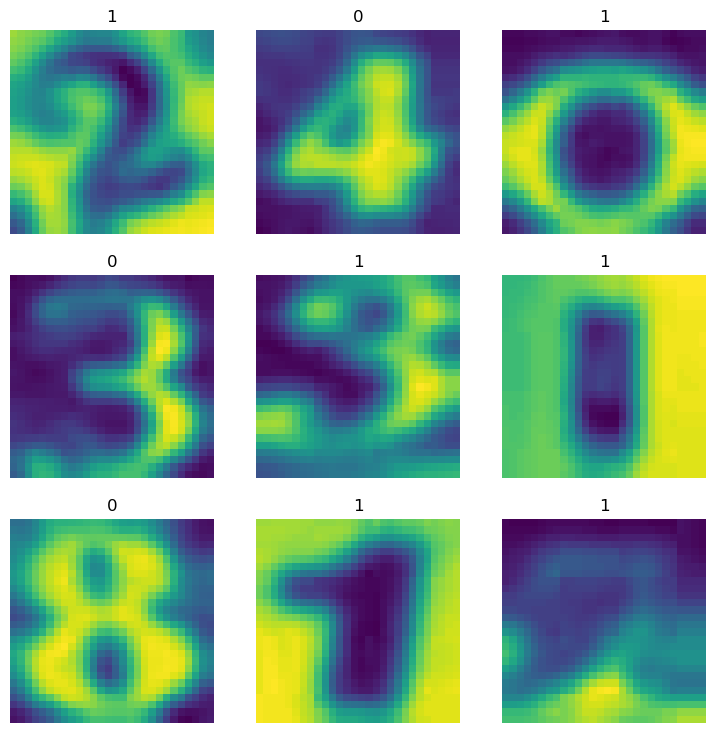

In [111]:
dls.show_batch()

In [112]:
f1score = F1Score(average='binary')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,f1_score,time
0,1.023701,0.696051,0.722222,00:03


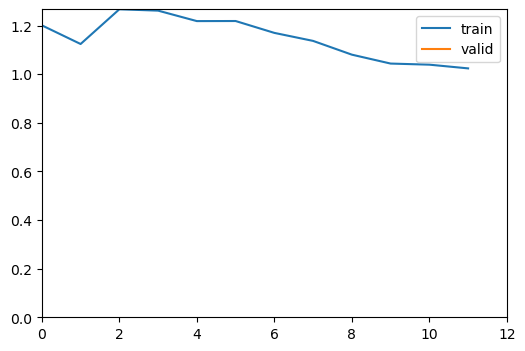

epoch,train_loss,valid_loss,f1_score,time
0,0.580834,0.591655,0.794393,00:03
1,0.471713,0.546044,0.805825,00:03
2,0.391376,0.375118,0.873239,00:03
3,0.308093,0.251079,0.915888,00:03
4,0.249051,0.263285,0.892019,00:03
5,0.205431,0.227970,0.934579,00:03
6,0.165799,0.197180,0.934579,00:03
7,0.132986,0.205818,0.938389,00:03
8,0.109594,0.167553,0.942857,00:03
9,0.090689,0.147872,0.953271,00:03


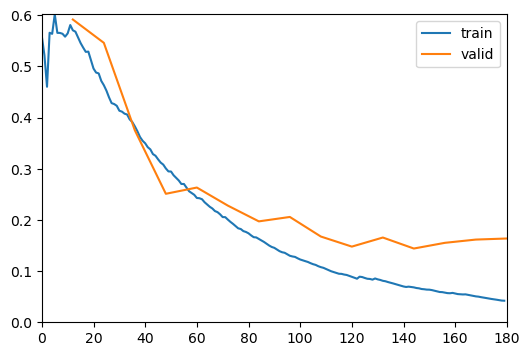

In [113]:
learn = vision_learner(dls,
                       resnet34,
                       metrics=f1score,
                       model_dir= '/kaggle/working/',
                       cbs=[ShowGraphCallback()]).to_fp16()
learn.fine_tune(15)

In [114]:
save_cb = SaveModelCallback(monitor='valid_loss', at_end=False, every_epoch=False, with_opt = True)
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss',min_delta=0.001 ,patience=10)

# Create a list of callbacks
callbacks = [save_cb,early_stop_cb]

epoch,train_loss,valid_loss,f1_score,time
0,0.006364,0.154293,0.947867,00:03
1,0.007105,0.154744,0.947368,00:02
2,0.013402,0.127220,0.947368,00:03
3,0.013559,0.123222,0.957346,00:03
4,0.014729,0.235505,0.937198,00:03
5,0.016749,0.250342,0.926829,00:03
6,0.020045,0.538570,0.882353,00:02
7,0.055112,0.447533,0.915423,00:03
8,0.117544,0.172598,0.948837,00:03
9,0.135658,0.500930,0.941176,00:03


Better model found at epoch 0 with valid_loss value: 0.15429268777370453.


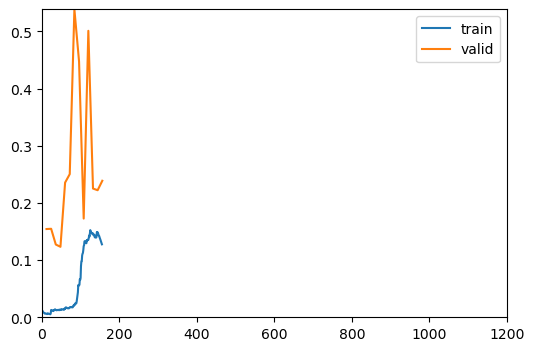

Better model found at epoch 2 with valid_loss value: 0.1272197663784027.
Better model found at epoch 3 with valid_loss value: 0.12322156131267548.
No improvement since epoch 3: early stopping


In [115]:
learn.fit_one_cycle(100, cbs=callbacks)

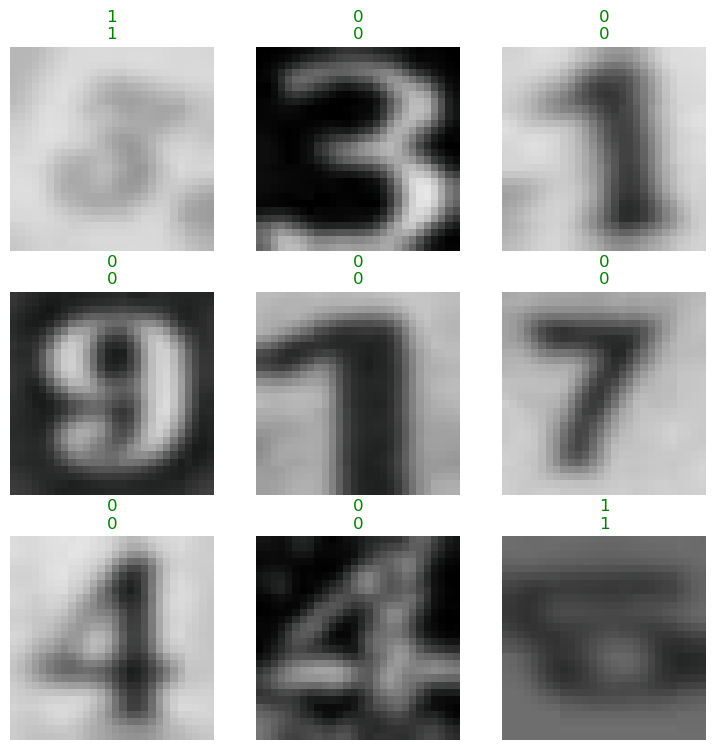

In [116]:
learn.show_results()

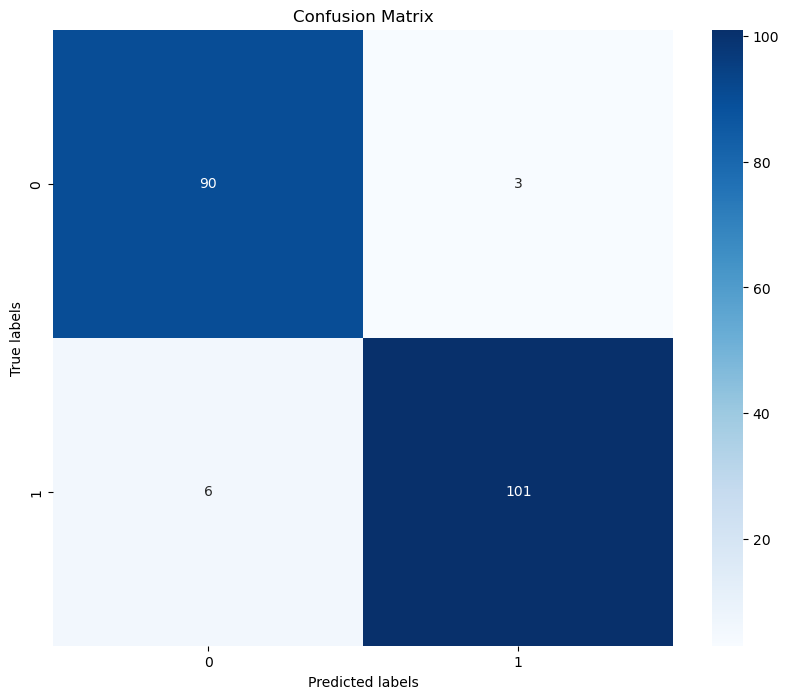

In [117]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain predictions on validation dataset
preds, targets = learn.get_preds(ds_idx=1)

# Convert predictions and targets to class labels
pred_labels = preds.argmax(dim=1)
target_labels = targets

# Compute confusion matrix
cm = confusion_matrix(target_labels, pred_labels)

# Display confusion matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

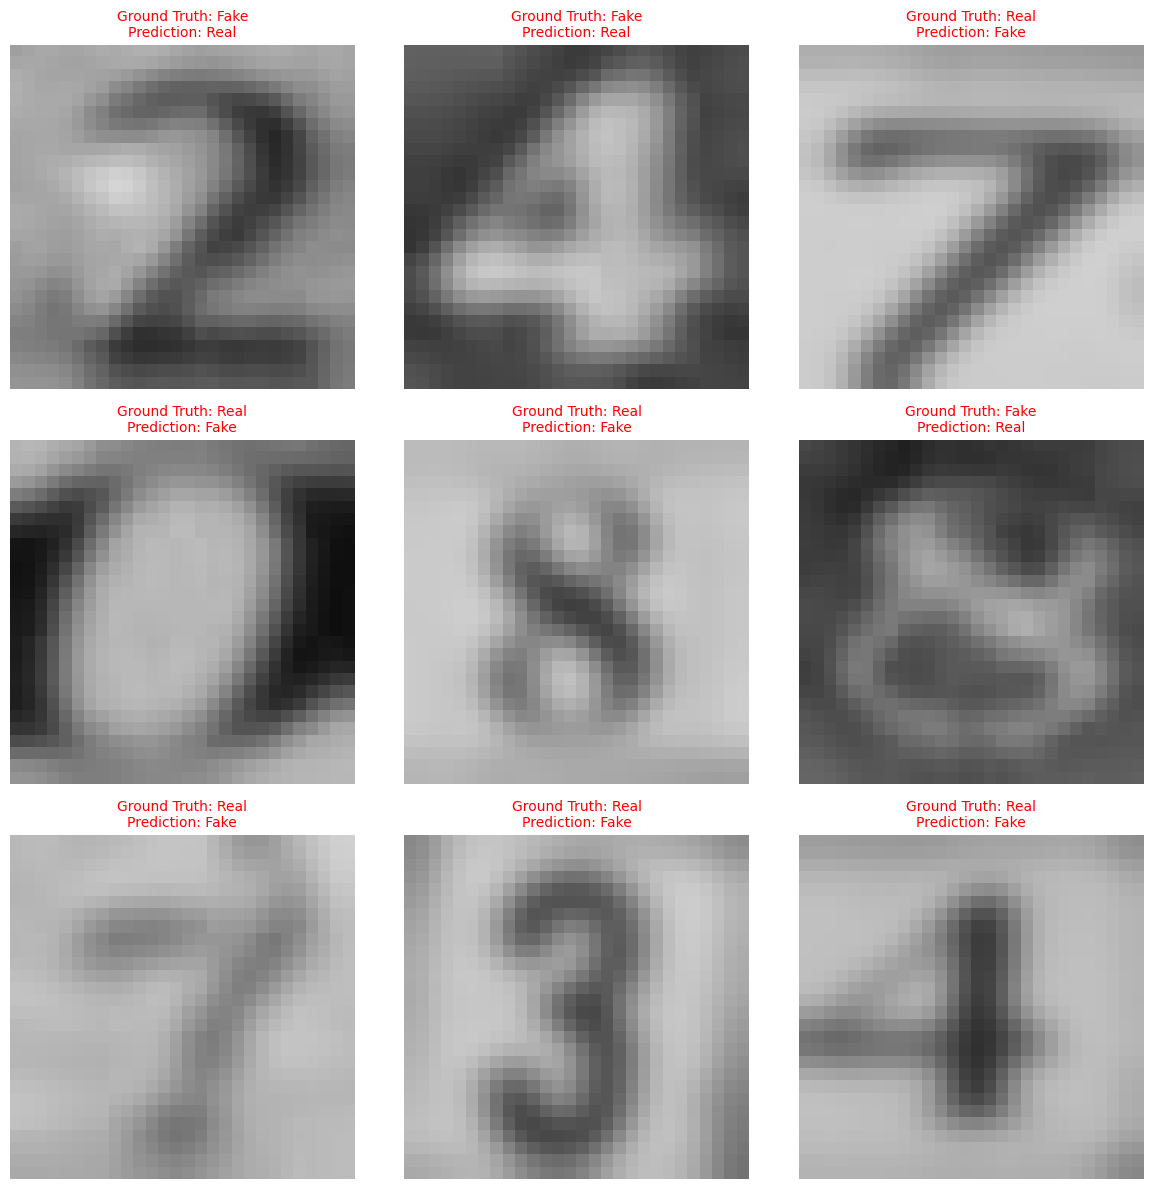

In [118]:
# Import necessary libraries
import torch
import matplotlib.pyplot as plt

# Get the indices of wrong predictions
wrong_prediction_indices = torch.nonzero(target_labels != pred_labels, as_tuple=False).squeeze()

# Number of images to visualize (you can adjust this as needed)
num_images_to_visualize = 9

# Create a 3x3 subplot to display the wrong predictions
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Plot the wrong predictions
for i in range(num_images_to_visualize):
    try:
        index = wrong_prediction_indices[i].item()

        # Get the true label and predicted label for this image
        true_label = target_labels[index].item()
        predicted_label = pred_labels[index].item()

        # Get the image data for this index
        image, _ = dls.valid_ds[index]  # Access the validation dataset using dls.valid_ds

        # Plot the image along with its true and predicted labels
        ax = axs[i // 3, i % 3]
        ax.imshow(image)
        ax.set_title(f"Ground Truth: {class_dict[true_label]}\nPrediction: {class_dict[predicted_label]}", fontsize=10, 
                     color='green' if true_label == predicted_label else 'red')
        ax.axis('off')
    except:
        print('No more')

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [119]:
test_df = pd.read_csv('/kaggle/input/hackathon-online-realfakenumbers/sample_submission.csv')

In [120]:
test_df.head()

,img_name,code
0,new_name_0.png,0.0
1,new_name_1.png,0.0
2,new_name_2.png,1.0
3,new_name_3.png,NaN
4,new_name_4.png,NaN


In [121]:
def process_example(image):
    return image.convert('L')

In [122]:
pred = []
for test_image in tqdm('/kaggle/input/hackathon-online-realfakenumbers/test_set-20230712T063018Z-001/test_set/test/' + test_df.img_name):
    image = Image.open(test_image)
    image = process_example(image)
    prediction = learn.predict(image)
    pred_label = int(prediction[1])
    pred.append(pred_label)

  0%|          | 0/1010 [00:00<?, ?it/s]

  0%|          | 3/1010 [00:00<00:40, 24.96it/s]

  1%|          | 6/1010 [00:00<00:38, 26.03it/s]

  1%|          | 9/1010 [00:00<00:37, 26.42it/s]

  1%|          | 12/1010 [00:00<00:37, 26.52it/s]

  1%|▏         | 15/1010 [00:00<00:37, 26.65it/s]

  2%|▏         | 18/1010 [00:00<00:37, 26.78it/s]

  2%|▏         | 21/1010 [00:00<00:36, 26.91it/s]

  2%|▏         | 24/1010 [00:00<00:36, 26.97it/s]

  3%|▎         | 27/1010 [00:01<00:36, 26.94it/s]

  3%|▎         | 30/1010 [00:01<00:39, 24.68it/s]

  3%|▎         | 33/1010 [00:01<00:41, 23.44it/s]

  4%|▎         | 36/1010 [00:01<00:42, 22.77it/s]

  4%|▍         | 39/1010 [00:01<00:44, 21.97it/s]

  4%|▍         | 42/1010 [00:01<00:45, 21.37it/s]

  4%|▍         | 45/1010 [00:01<00:46, 20.59it/s]

  5%|▍         | 48/1010 [00:02<00:47, 20.37it/s]

  5%|▌         | 51/1010 [00:02<00:46, 20.68it/s]

  5%|▌         | 54/1010 [00:02<00:45, 20.88it/s]

  6%|▌         | 57/1010 [00:02<00:45, 21.10it/s]

  6%|▌         | 60/1010 [00:02<00:45, 21.02it/s]

  6%|▌         | 63/1010 [00:02<00:44, 21.07it/s]

  7%|▋         | 66/1010 [00:02<00:44, 21.11it/s]

  7%|▋         | 69/1010 [00:03<00:43, 21.66it/s]

  7%|▋         | 72/1010 [00:03<00:40, 23.19it/s]

  7%|▋         | 75/1010 [00:03<00:48, 19.38it/s]

  8%|▊         | 78/1010 [00:03<00:46, 19.88it/s]

  8%|▊         | 81/1010 [00:03<00:46, 20.16it/s]

  8%|▊         | 84/1010 [00:03<00:46, 20.02it/s]

  9%|▊         | 87/1010 [00:03<00:45, 20.42it/s]

  9%|▉         | 90/1010 [00:04<00:44, 20.55it/s]

  9%|▉         | 93/1010 [00:04<00:44, 20.52it/s]

 10%|▉         | 96/1010 [00:04<00:43, 21.03it/s]

 10%|▉         | 99/1010 [00:04<00:42, 21.26it/s]

 10%|█         | 102/1010 [00:04<00:42, 21.30it/s]

 10%|█         | 105/1010 [00:04<00:42, 21.15it/s]

 11%|█         | 108/1010 [00:04<00:43, 20.87it/s]

 11%|█         | 111/1010 [00:05<00:42, 20.94it/s]

 11%|█▏        | 114/1010 [00:05<00:42, 21.12it/s]

 12%|█▏        | 117/1010 [00:05<00:42, 20.90it/s]

 12%|█▏        | 120/1010 [00:05<00:42, 21.10it/s]

 12%|█▏        | 123/1010 [00:05<00:42, 21.02it/s]

 12%|█▏        | 126/1010 [00:05<00:42, 20.76it/s]

 13%|█▎        | 129/1010 [00:05<00:42, 20.70it/s]

 13%|█▎        | 132/1010 [00:06<00:43, 20.04it/s]

 13%|█▎        | 135/1010 [00:06<00:44, 19.78it/s]

 14%|█▎        | 138/1010 [00:06<00:42, 20.35it/s]

 14%|█▍        | 141/1010 [00:06<00:40, 21.59it/s]

 14%|█▍        | 144/1010 [00:06<00:37, 22.95it/s]

 15%|█▍        | 147/1010 [00:06<00:35, 23.98it/s]

 15%|█▍        | 150/1010 [00:06<00:34, 24.85it/s]

 15%|█▌        | 153/1010 [00:06<00:36, 23.54it/s]

 15%|█▌        | 156/1010 [00:07<00:37, 22.71it/s]

 16%|█▌        | 159/1010 [00:07<00:38, 22.21it/s]

 16%|█▌        | 162/1010 [00:07<00:38, 22.30it/s]

 16%|█▋        | 165/1010 [00:07<00:35, 23.50it/s]

 17%|█▋        | 168/1010 [00:07<00:34, 24.62it/s]

 17%|█▋        | 171/1010 [00:07<00:33, 25.07it/s]

 17%|█▋        | 174/1010 [00:07<00:32, 25.69it/s]

 18%|█▊        | 177/1010 [00:07<00:31, 26.19it/s]

 18%|█▊        | 180/1010 [00:08<00:31, 26.25it/s]

 18%|█▊        | 183/1010 [00:08<00:32, 25.70it/s]

 18%|█▊        | 186/1010 [00:08<00:31, 26.06it/s]

 19%|█▊        | 189/1010 [00:08<00:31, 26.08it/s]

 19%|█▉        | 192/1010 [00:08<00:31, 26.07it/s]

 19%|█▉        | 195/1010 [00:08<00:31, 25.87it/s]

 20%|█▉        | 198/1010 [00:08<00:31, 26.12it/s]

 20%|█▉        | 201/1010 [00:08<00:30, 26.45it/s]

 20%|██        | 204/1010 [00:08<00:30, 26.65it/s]

 20%|██        | 207/1010 [00:09<00:30, 26.75it/s]

 21%|██        | 210/1010 [00:09<00:29, 26.85it/s]

 21%|██        | 213/1010 [00:09<00:29, 27.00it/s]

 21%|██▏       | 216/1010 [00:09<00:29, 26.90it/s]

 22%|██▏       | 219/1010 [00:09<00:29, 27.14it/s]

 22%|██▏       | 222/1010 [00:09<00:28, 27.21it/s]

 22%|██▏       | 225/1010 [00:09<00:29, 26.95it/s]

 23%|██▎       | 228/1010 [00:09<00:28, 27.03it/s]

 23%|██▎       | 231/1010 [00:09<00:29, 26.85it/s]

 23%|██▎       | 234/1010 [00:10<00:28, 27.05it/s]

 23%|██▎       | 237/1010 [00:10<00:28, 27.33it/s]

 24%|██▍       | 240/1010 [00:10<00:27, 27.55it/s]

 24%|██▍       | 243/1010 [00:10<00:28, 27.13it/s]

 24%|██▍       | 246/1010 [00:10<00:27, 27.38it/s]

 25%|██▍       | 249/1010 [00:10<00:27, 27.53it/s]

 25%|██▍       | 252/1010 [00:10<00:27, 27.35it/s]

 25%|██▌       | 255/1010 [00:10<00:27, 27.37it/s]

 26%|██▌       | 258/1010 [00:10<00:27, 27.42it/s]

 26%|██▌       | 261/1010 [00:11<00:27, 27.26it/s]

 26%|██▌       | 264/1010 [00:11<00:27, 27.30it/s]

 26%|██▋       | 267/1010 [00:11<00:27, 26.96it/s]

 27%|██▋       | 270/1010 [00:11<00:27, 26.60it/s]

 27%|██▋       | 273/1010 [00:11<00:27, 27.03it/s]

 27%|██▋       | 276/1010 [00:11<00:27, 27.16it/s]

 28%|██▊       | 279/1010 [00:11<00:29, 24.95it/s]

 28%|██▊       | 282/1010 [00:11<00:30, 23.78it/s]

 28%|██▊       | 285/1010 [00:12<00:31, 22.94it/s]

 29%|██▊       | 288/1010 [00:12<00:32, 22.43it/s]

 29%|██▉       | 291/1010 [00:12<00:32, 22.17it/s]

 29%|██▉       | 294/1010 [00:12<00:32, 21.90it/s]

 29%|██▉       | 297/1010 [00:12<00:32, 21.87it/s]

 30%|██▉       | 300/1010 [00:12<00:33, 21.51it/s]

 30%|███       | 303/1010 [00:12<00:33, 21.37it/s]

 30%|███       | 306/1010 [00:13<00:33, 20.71it/s]

 31%|███       | 309/1010 [00:13<00:33, 20.96it/s]

 31%|███       | 312/1010 [00:13<00:36, 18.92it/s]

 31%|███       | 315/1010 [00:13<00:35, 19.63it/s]

 31%|███▏      | 318/1010 [00:13<00:34, 19.82it/s]

 32%|███▏      | 321/1010 [00:13<00:34, 20.05it/s]

 32%|███▏      | 324/1010 [00:13<00:33, 20.34it/s]

 32%|███▏      | 327/1010 [00:14<00:33, 20.51it/s]

 33%|███▎      | 330/1010 [00:14<00:32, 20.64it/s]

 33%|███▎      | 333/1010 [00:14<00:33, 20.25it/s]

 33%|███▎      | 336/1010 [00:14<00:31, 21.38it/s]

 34%|███▎      | 339/1010 [00:14<00:29, 22.91it/s]

 34%|███▍      | 342/1010 [00:14<00:27, 23.94it/s]

 34%|███▍      | 345/1010 [00:14<00:26, 24.72it/s]

 34%|███▍      | 348/1010 [00:14<00:26, 25.45it/s]

 35%|███▍      | 351/1010 [00:15<00:25, 25.97it/s]

 35%|███▌      | 354/1010 [00:15<00:26, 24.56it/s]

 35%|███▌      | 357/1010 [00:15<00:28, 22.76it/s]

 36%|███▌      | 360/1010 [00:15<00:29, 22.19it/s]

 36%|███▌      | 363/1010 [00:15<00:29, 21.95it/s]

 36%|███▌      | 366/1010 [00:15<00:29, 21.55it/s]

 37%|███▋      | 369/1010 [00:15<00:29, 21.39it/s]

 37%|███▋      | 372/1010 [00:16<00:30, 21.25it/s]

 37%|███▋      | 375/1010 [00:16<00:29, 21.32it/s]

 37%|███▋      | 378/1010 [00:16<00:29, 21.36it/s]

 38%|███▊      | 381/1010 [00:16<00:29, 21.19it/s]

 38%|███▊      | 384/1010 [00:16<00:29, 21.31it/s]

 38%|███▊      | 387/1010 [00:16<00:29, 21.19it/s]

 39%|███▊      | 390/1010 [00:16<00:27, 22.50it/s]

 39%|███▉      | 393/1010 [00:17<00:25, 23.74it/s]

 39%|███▉      | 396/1010 [00:17<00:24, 24.69it/s]

 40%|███▉      | 399/1010 [00:17<00:24, 25.15it/s]

 40%|███▉      | 402/1010 [00:17<00:23, 25.82it/s]

 40%|████      | 405/1010 [00:17<00:23, 26.03it/s]

 40%|████      | 408/1010 [00:17<00:23, 26.15it/s]

 41%|████      | 411/1010 [00:17<00:23, 25.89it/s]

 41%|████      | 414/1010 [00:17<00:22, 26.31it/s]

 41%|████▏     | 417/1010 [00:17<00:22, 26.62it/s]

 42%|████▏     | 420/1010 [00:18<00:22, 26.67it/s]

 42%|████▏     | 423/1010 [00:18<00:24, 24.34it/s]

 42%|████▏     | 426/1010 [00:18<00:29, 19.80it/s]

 42%|████▏     | 429/1010 [00:18<00:35, 16.50it/s]

 43%|████▎     | 431/1010 [00:18<00:37, 15.46it/s]

 43%|████▎     | 433/1010 [00:18<00:38, 14.82it/s]

 43%|████▎     | 435/1010 [00:19<00:40, 14.18it/s]

 43%|████▎     | 437/1010 [00:19<00:41, 13.85it/s]

 43%|████▎     | 439/1010 [00:19<00:41, 13.76it/s]

 44%|████▎     | 441/1010 [00:19<00:42, 13.55it/s]

 44%|████▍     | 443/1010 [00:19<00:43, 13.15it/s]

 44%|████▍     | 446/1010 [00:19<00:37, 15.23it/s]

 44%|████▍     | 449/1010 [00:20<00:33, 16.92it/s]

 45%|████▍     | 452/1010 [00:20<00:30, 18.05it/s]

 45%|████▌     | 455/1010 [00:20<00:29, 19.01it/s]

 45%|████▌     | 458/1010 [00:20<00:28, 19.64it/s]

 46%|████▌     | 461/1010 [00:20<00:27, 20.12it/s]

 46%|████▌     | 464/1010 [00:20<00:26, 20.34it/s]

 46%|████▌     | 467/1010 [00:20<00:26, 20.65it/s]

 47%|████▋     | 470/1010 [00:21<00:26, 20.63it/s]

 47%|████▋     | 473/1010 [00:21<00:25, 20.67it/s]

 47%|████▋     | 476/1010 [00:21<00:25, 20.74it/s]

 47%|████▋     | 479/1010 [00:21<00:25, 20.83it/s]

 48%|████▊     | 482/1010 [00:21<00:25, 20.97it/s]

 48%|████▊     | 485/1010 [00:21<00:25, 20.89it/s]

 48%|████▊     | 488/1010 [00:21<00:24, 21.07it/s]

 49%|████▊     | 491/1010 [00:22<00:24, 21.10it/s]

 49%|████▉     | 494/1010 [00:22<00:24, 21.02it/s]

 49%|████▉     | 497/1010 [00:22<00:24, 21.05it/s]

 50%|████▉     | 500/1010 [00:22<00:23, 21.93it/s]

 50%|████▉     | 503/1010 [00:22<00:21, 23.30it/s]

 50%|█████     | 506/1010 [00:22<00:20, 24.22it/s]

 50%|█████     | 509/1010 [00:22<00:20, 24.94it/s]

 51%|█████     | 512/1010 [00:22<00:19, 25.33it/s]

 51%|█████     | 515/1010 [00:22<00:19, 24.95it/s]

 51%|█████▏    | 518/1010 [00:23<00:19, 25.40it/s]

 52%|█████▏    | 521/1010 [00:23<00:19, 24.67it/s]

 52%|█████▏    | 524/1010 [00:23<00:21, 22.18it/s]

 52%|█████▏    | 527/1010 [00:23<00:20, 23.47it/s]

 52%|█████▏    | 530/1010 [00:23<00:19, 24.38it/s]

 53%|█████▎    | 533/1010 [00:23<00:19, 24.69it/s]

 53%|█████▎    | 536/1010 [00:23<00:18, 25.36it/s]

 53%|█████▎    | 539/1010 [00:23<00:18, 25.87it/s]

 54%|█████▎    | 542/1010 [00:24<00:17, 26.24it/s]

 54%|█████▍    | 545/1010 [00:24<00:18, 24.57it/s]

 54%|█████▍    | 548/1010 [00:24<00:19, 23.53it/s]

 55%|█████▍    | 551/1010 [00:24<00:20, 22.63it/s]

 55%|█████▍    | 554/1010 [00:24<00:20, 22.18it/s]

 55%|█████▌    | 557/1010 [00:24<00:20, 21.76it/s]

 55%|█████▌    | 560/1010 [00:24<00:20, 21.60it/s]

 56%|█████▌    | 563/1010 [00:25<00:20, 21.36it/s]

 56%|█████▌    | 566/1010 [00:25<00:20, 21.42it/s]

 56%|█████▋    | 569/1010 [00:25<00:20, 21.37it/s]

 57%|█████▋    | 572/1010 [00:25<00:20, 21.16it/s]

 57%|█████▋    | 575/1010 [00:25<00:20, 21.05it/s]

 57%|█████▋    | 578/1010 [00:25<00:20, 20.66it/s]

 58%|█████▊    | 581/1010 [00:25<00:20, 20.74it/s]

 58%|█████▊    | 584/1010 [00:26<00:20, 20.60it/s]

 58%|█████▊    | 587/1010 [00:26<00:20, 20.77it/s]

 58%|█████▊    | 590/1010 [00:26<00:20, 20.83it/s]

 59%|█████▊    | 593/1010 [00:26<00:20, 20.76it/s]

 59%|█████▉    | 596/1010 [00:26<00:19, 20.84it/s]

 59%|█████▉    | 599/1010 [00:26<00:19, 20.67it/s]

 60%|█████▉    | 602/1010 [00:26<00:20, 20.31it/s]

 60%|█████▉    | 605/1010 [00:27<00:19, 20.63it/s]

 60%|██████    | 608/1010 [00:27<00:19, 20.70it/s]

 60%|██████    | 611/1010 [00:27<00:19, 20.77it/s]

 61%|██████    | 614/1010 [00:27<00:19, 20.76it/s]

 61%|██████    | 617/1010 [00:27<00:18, 20.83it/s]

 61%|██████▏   | 620/1010 [00:27<00:18, 20.77it/s]

 62%|██████▏   | 623/1010 [00:27<00:18, 20.81it/s]

 62%|██████▏   | 626/1010 [00:28<00:18, 20.95it/s]

 62%|██████▏   | 629/1010 [00:28<00:18, 20.70it/s]

 63%|██████▎   | 632/1010 [00:28<00:18, 20.90it/s]

 63%|██████▎   | 635/1010 [00:28<00:18, 20.78it/s]

 63%|██████▎   | 638/1010 [00:28<00:17, 20.95it/s]

 63%|██████▎   | 641/1010 [00:28<00:17, 20.88it/s]

 64%|██████▍   | 644/1010 [00:28<00:17, 20.81it/s]

 64%|██████▍   | 647/1010 [00:29<00:17, 20.92it/s]

 64%|██████▍   | 650/1010 [00:29<00:17, 21.05it/s]

 65%|██████▍   | 653/1010 [00:29<00:16, 21.18it/s]

 65%|██████▍   | 656/1010 [00:29<00:16, 21.09it/s]

 65%|██████▌   | 659/1010 [00:29<00:16, 21.00it/s]

 66%|██████▌   | 662/1010 [00:29<00:16, 20.70it/s]

 66%|██████▌   | 665/1010 [00:29<00:16, 20.86it/s]

 66%|██████▌   | 668/1010 [00:30<00:16, 20.85it/s]

 66%|██████▋   | 671/1010 [00:30<00:16, 20.85it/s]

 67%|██████▋   | 674/1010 [00:30<00:15, 21.05it/s]

 67%|██████▋   | 677/1010 [00:30<00:15, 21.67it/s]

 67%|██████▋   | 680/1010 [00:30<00:14, 22.99it/s]

 68%|██████▊   | 683/1010 [00:30<00:13, 23.61it/s]

 68%|██████▊   | 686/1010 [00:30<00:14, 22.60it/s]

 68%|██████▊   | 689/1010 [00:31<00:14, 21.99it/s]

 69%|██████▊   | 692/1010 [00:31<00:14, 21.70it/s]

 69%|██████▉   | 695/1010 [00:31<00:14, 21.45it/s]

 69%|██████▉   | 698/1010 [00:31<00:14, 21.35it/s]

 69%|██████▉   | 701/1010 [00:31<00:14, 21.37it/s]

 70%|██████▉   | 704/1010 [00:31<00:14, 21.01it/s]

 70%|███████   | 707/1010 [00:31<00:14, 21.13it/s]

 70%|███████   | 710/1010 [00:32<00:14, 21.00it/s]

 71%|███████   | 713/1010 [00:32<00:14, 21.14it/s]

 71%|███████   | 716/1010 [00:32<00:14, 20.94it/s]

 71%|███████   | 719/1010 [00:32<00:13, 20.98it/s]

 71%|███████▏  | 722/1010 [00:32<00:13, 21.11it/s]

 72%|███████▏  | 725/1010 [00:32<00:13, 21.07it/s]

 72%|███████▏  | 728/1010 [00:32<00:13, 21.19it/s]

 72%|███████▏  | 731/1010 [00:33<00:14, 18.96it/s]

 73%|███████▎  | 734/1010 [00:33<00:15, 18.21it/s]

 73%|███████▎  | 736/1010 [00:33<00:14, 18.49it/s]

 73%|███████▎  | 739/1010 [00:33<00:13, 20.27it/s]

 73%|███████▎  | 742/1010 [00:33<00:12, 21.85it/s]

 74%|███████▍  | 745/1010 [00:33<00:11, 23.50it/s]

 74%|███████▍  | 748/1010 [00:33<00:10, 24.59it/s]

 74%|███████▍  | 751/1010 [00:33<00:10, 24.76it/s]

 75%|███████▍  | 754/1010 [00:34<00:10, 24.57it/s]

 75%|███████▍  | 757/1010 [00:34<00:10, 25.29it/s]

 75%|███████▌  | 760/1010 [00:34<00:09, 25.11it/s]

 76%|███████▌  | 763/1010 [00:34<00:09, 25.81it/s]

 76%|███████▌  | 766/1010 [00:34<00:09, 25.83it/s]

 76%|███████▌  | 769/1010 [00:34<00:09, 26.28it/s]

 76%|███████▋  | 772/1010 [00:34<00:08, 26.57it/s]

 77%|███████▋  | 775/1010 [00:34<00:08, 26.39it/s]

 77%|███████▋  | 778/1010 [00:34<00:08, 26.04it/s]

 77%|███████▋  | 781/1010 [00:35<00:08, 26.22it/s]

 78%|███████▊  | 784/1010 [00:35<00:08, 26.39it/s]

 78%|███████▊  | 787/1010 [00:35<00:08, 26.07it/s]

 78%|███████▊  | 790/1010 [00:35<00:08, 25.87it/s]

 79%|███████▊  | 793/1010 [00:35<00:09, 24.08it/s]

 79%|███████▉  | 796/1010 [00:35<00:09, 23.15it/s]

 79%|███████▉  | 799/1010 [00:35<00:09, 22.51it/s]

 79%|███████▉  | 802/1010 [00:36<00:09, 22.14it/s]

 80%|███████▉  | 805/1010 [00:36<00:09, 21.75it/s]

 80%|████████  | 808/1010 [00:36<00:09, 21.63it/s]

 80%|████████  | 811/1010 [00:36<00:09, 21.68it/s]

 81%|████████  | 814/1010 [00:36<00:09, 21.03it/s]

 81%|████████  | 817/1010 [00:36<00:09, 20.32it/s]

 81%|████████  | 820/1010 [00:36<00:09, 20.36it/s]

 81%|████████▏ | 823/1010 [00:37<00:09, 20.36it/s]

 82%|████████▏ | 826/1010 [00:37<00:08, 20.56it/s]

 82%|████████▏ | 829/1010 [00:37<00:08, 20.75it/s]

 82%|████████▏ | 832/1010 [00:37<00:08, 20.84it/s]

 83%|████████▎ | 835/1010 [00:37<00:08, 20.90it/s]

 83%|████████▎ | 838/1010 [00:37<00:08, 20.91it/s]

 83%|████████▎ | 841/1010 [00:37<00:08, 20.97it/s]

 84%|████████▎ | 844/1010 [00:38<00:07, 20.75it/s]

 84%|████████▍ | 847/1010 [00:38<00:07, 20.66it/s]

 84%|████████▍ | 850/1010 [00:38<00:07, 20.67it/s]

 84%|████████▍ | 853/1010 [00:38<00:07, 20.89it/s]

 85%|████████▍ | 856/1010 [00:38<00:07, 20.64it/s]

 85%|████████▌ | 859/1010 [00:38<00:07, 20.71it/s]

 85%|████████▌ | 862/1010 [00:38<00:07, 20.85it/s]

 86%|████████▌ | 865/1010 [00:39<00:06, 20.94it/s]

 86%|████████▌ | 868/1010 [00:39<00:06, 21.06it/s]

 86%|████████▌ | 871/1010 [00:39<00:06, 21.23it/s]

 87%|████████▋ | 874/1010 [00:39<00:06, 21.32it/s]

 87%|████████▋ | 877/1010 [00:39<00:06, 21.07it/s]

 87%|████████▋ | 880/1010 [00:39<00:06, 21.04it/s]

 87%|████████▋ | 883/1010 [00:39<00:06, 21.12it/s]

 88%|████████▊ | 886/1010 [00:40<00:05, 21.03it/s]

 88%|████████▊ | 889/1010 [00:40<00:05, 21.03it/s]

 88%|████████▊ | 892/1010 [00:40<00:05, 21.09it/s]

 89%|████████▊ | 895/1010 [00:40<00:05, 21.22it/s]

 89%|████████▉ | 898/1010 [00:40<00:05, 21.14it/s]

 89%|████████▉ | 901/1010 [00:40<00:05, 21.14it/s]

 90%|████████▉ | 904/1010 [00:40<00:05, 21.14it/s]

 90%|████████▉ | 907/1010 [00:41<00:04, 21.13it/s]

 90%|█████████ | 910/1010 [00:41<00:04, 20.91it/s]

 90%|█████████ | 913/1010 [00:41<00:04, 21.00it/s]

 91%|█████████ | 916/1010 [00:41<00:04, 21.11it/s]

 91%|█████████ | 919/1010 [00:41<00:04, 21.01it/s]

 91%|█████████▏| 922/1010 [00:41<00:04, 20.90it/s]

 92%|█████████▏| 925/1010 [00:41<00:04, 20.97it/s]

 92%|█████████▏| 928/1010 [00:42<00:03, 21.04it/s]

 92%|█████████▏| 931/1010 [00:42<00:03, 21.04it/s]

 92%|█████████▏| 934/1010 [00:42<00:03, 21.10it/s]

 93%|█████████▎| 937/1010 [00:42<00:03, 21.18it/s]

 93%|█████████▎| 940/1010 [00:42<00:03, 21.10it/s]

 93%|█████████▎| 943/1010 [00:42<00:03, 21.04it/s]

 94%|█████████▎| 946/1010 [00:42<00:03, 21.12it/s]

 94%|█████████▍| 949/1010 [00:43<00:02, 21.64it/s]

 94%|█████████▍| 952/1010 [00:43<00:02, 21.51it/s]

 95%|█████████▍| 955/1010 [00:43<00:02, 18.65it/s]

 95%|█████████▍| 958/1010 [00:43<00:02, 18.99it/s]

 95%|█████████▌| 961/1010 [00:43<00:02, 19.65it/s]

 95%|█████████▌| 964/1010 [00:43<00:02, 20.03it/s]

 96%|█████████▌| 967/1010 [00:43<00:02, 20.34it/s]

 96%|█████████▌| 970/1010 [00:44<00:01, 20.65it/s]

 96%|█████████▋| 973/1010 [00:44<00:01, 20.76it/s]

 97%|█████████▋| 976/1010 [00:44<00:01, 20.97it/s]

 97%|█████████▋| 979/1010 [00:44<00:01, 20.99it/s]

 97%|█████████▋| 982/1010 [00:44<00:01, 21.02it/s]

 98%|█████████▊| 985/1010 [00:44<00:01, 21.12it/s]

 98%|█████████▊| 988/1010 [00:44<00:01, 21.26it/s]

 98%|█████████▊| 991/1010 [00:45<00:00, 21.34it/s]

 98%|█████████▊| 994/1010 [00:45<00:00, 21.36it/s]

 99%|█████████▊| 997/1010 [00:45<00:00, 21.09it/s]

 99%|█████████▉| 1000/1010 [00:45<00:00, 21.18it/s]

 99%|█████████▉| 1003/1010 [00:45<00:00, 20.75it/s]

100%|█████████▉| 1006/1010 [00:45<00:00, 20.88it/s]

100%|█████████▉| 1009/1010 [00:45<00:00, 21.00it/s]

100%|██████████| 1010/1010 [00:45<00:00, 21.96it/s]


In [123]:
test_df['code'] = pred

In [124]:
test_df.to_csv('my_thrid_submission_grayscale.csv', index = False)

In [125]:
test_df.code.value_counts()

0    756
1    254
Name: code, dtype: int64